In [1]:
import librosa
import librosa.display
import soundfile as sf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import csv
import json

In [25]:
def _writePredictionsTofile(ids, predictions):
    with open("predictions.csv", "w", newline="") as file:
        fieldnames = ["id", "genre"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        size = len(ids)
        for x in range(size):
            writer.writerow({"id": ids[x], "genre": predictions[x]})

In [3]:
def _mapTrainFilesIDToGenre():
    id_genre_dict = dict()
    with open("train.csv", "r") as file:
        csvFile = csv.reader(file)
        for row in csvFile:
            id = row[0]
            id_len = len(id)
            N = 8 - id_len
            id = id.rjust(N + len(id), '0')
            genre = row[1]
            id_genre_dict[id] = genre
    
    if "new_id" in id_genre_dict:

        id_genre_dict.pop("new_id")
    
    return id_genre_dict

In [3]:
def _checkLengthOfAudioFiles(data_dir):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    ls = []
    for i in range (size):
        audio_data, sr = librosa.load(audio_files_arr[i])
        if(len(ls) == 0):
            ls.append(len(audio_data))

        else:
            if ls[0] != len(audio_data):
                print("data have different size")
                break

In [4]:
def _getLowestDuration(data_dir):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    duration_ls = []
    for i in range (size):
        audio_data, sr = librosa.load(audio_files_arr[i])
        duration = len(audio_data) / sr
        duration_ls.append(duration)
    
    return min(duration_ls)


In [5]:
#Visualize an STFT power spectrum using default parameters
def _specshow(dir):
    audio_files_arr = glob(dir + '/*.mp3')
    size = len(audio_files_arr)
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i], duration=29)
        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
        ax[0].set(title='Linear-frequency power spectrogram')
        ax[0].label_outer()

In [6]:
#_specshow("small_set")

In [8]:
def _getPCAComponentLs(data_dir,duration):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    ls = []
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i],duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        scaler = StandardScaler()
        mfcc_rescaled = scaler.fit_transform(mfcc)
        pca = PCA(n_components = 0.999)
        pca.fit(mfcc_rescaled)
        
        reduced_mfcc = pca.transform(mfcc_rescaled)
        ls.append(len(pca.components_))
    return ls


In [8]:
#Not necessary cuz get lowest duration takes care of this
#_checkLengthOfAudioFiles("train")

In [9]:
#duration_to_read = _getLowestDuration("train")
#29.976598639455784

In [2]:
duration_to_read = 29

In [ ]:
#mfcc_component_ls = _getPCAComponentLs("train",duration_to_read)

In [10]:
def _getPCAComponentCENS(data_dir,duration):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    ls = []
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i],duration=duration)
        chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
        scaler = StandardScaler()
        cens_rescaled = scaler.fit_transform(chroma_cens)
        pca = PCA(n_components = 0.999)
        pca.fit(cens_rescaled)
        
        reduced_cens = pca.transform(cens_rescaled)
        ls.append(len(pca.components_))
    return ls

In [ ]:
#cens_component_ls = _getPCAComponentCENS("train", duration_to_read)

In [5]:
MFCC_COMPONENTS = 17
CENS_COMPONENTS = 11

In [34]:
def _saveMFCCToJSon(data_dir,duration, id_class_dict):
  jason_data = {
      "mfccs": [],
      "labels": []
  }
  audio_files_arr = glob(data_dir + '/*.mp3')
  size = len(audio_files_arr)
  for i in range(size):
    audio_path = audio_files_arr[i]                 
    id = audio_path[6:14]           
    y, sr = librosa.load(audio_path,duration=duration)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    scaler = StandardScaler()
    mfcc_rescaled = scaler.fit_transform(mfcc)
    pca = PCA(n_components = MFCC_COMPONENTS)
    pca.fit(mfcc_rescaled)
    reduced_mfcc = pca.transform(mfcc_rescaled)

    jason_data["mfccs"].append(reduced_mfcc.tolist())
    genre = id_class_dict[id]
    jason_data["labels"].append(genre)

  with open('mfcc.json', "w") as json_file:
    json.dump(jason_data, json_file, indent = 2)

In [13]:
def _saveCENSToJson(data_dir,duration, id_class_dict):
  jason_data = {
      "cens": [],
      "labels": []
  }
  audio_files_arr = glob(data_dir + '/*.mp3')
  size = len(audio_files_arr)
  for i in range(size):
    audio_path = audio_files_arr[i]                 
    id = audio_path[6:14]           
    y, sr = librosa.load(audio_path,duration=duration)
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    scaler = StandardScaler()
    chroma_rescaled = scaler.fit_transform(chroma)
    pca = PCA(n_components = CENS_COMPONENTS)
    pca.fit(chroma_rescaled)
    cens = pca.transform(chroma_rescaled)

    jason_data["cens"].append(cens.tolist())
    genre = id_class_dict[id]
    jason_data["labels"].append(genre)

  with open('cens.json', "w") as json_file:
    json.dump(jason_data, json_file, indent = 2)

In [6]:
id_class_dict = _mapTrainFilesIDToGenre()

In [ ]:
# _saveMFCCToJSon("train",duration_to_read, id_class_dict)

In [ ]:
# _saveCENSToJson("train",duration_to_read, id_class_dict)

# Part 1: Data Processing and Representation

## 1.1 Representing data as a time series 

In [3]:
# Returns audio time series as a numpy array 
# default rate(sr) or 22KHZ
# Sample rate (sr) = the number of samples of audio carried per second, measured in Hz or kHz.
sample_path = './small_set/00907483.mp3'
x, sr = librosa.load(sample_path)
# print(type(x), type(sr))
# print(x.shape, sr)

/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


(-1.0, 1.0)

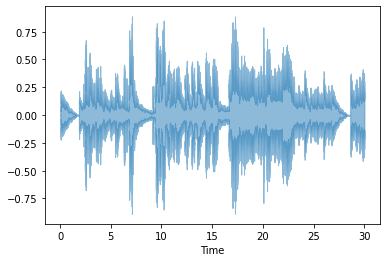

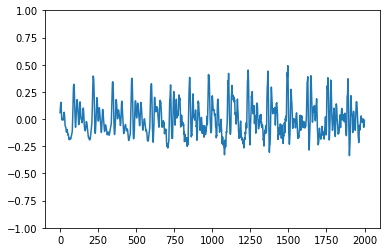

In [7]:
start, end = 7, 17

# Compute and display signal time series 
# From: https://nbviewer.org/github/mdeff/fma/blob/outputs/usage.ipynb
# waveshow documentation: http://librosa.org/doc/0.8.1/generated/librosa.display.waveshow.html#librosa.display.waveshow 
librosa.display.waveshow(x, sr, alpha=0.5)
# plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1))

## 1.2 Representing data as images (spectrograms)

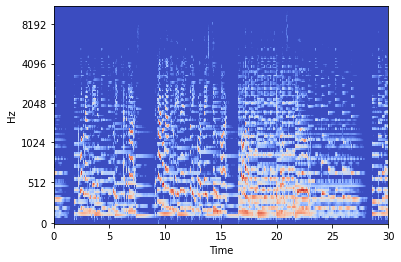

In [3]:
# Compute and display spectrogram
# From: https://nbviewer.org/github/mdeff/fma/blob/outputs/usage.ipynb

stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

## 1.3 Display MFCC Features

In [4]:
def _displayMFCC(data_dir,duration):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i],duration=duration)

        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        print("MFCC shape", mfcc.shape)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
        

/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


MFCC shape (20, 1249)


/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


MFCC shape (20, 1249)


/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


MFCC shape (20, 1249)


/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


MFCC shape (20, 1249)


/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


MFCC shape (20, 1249)


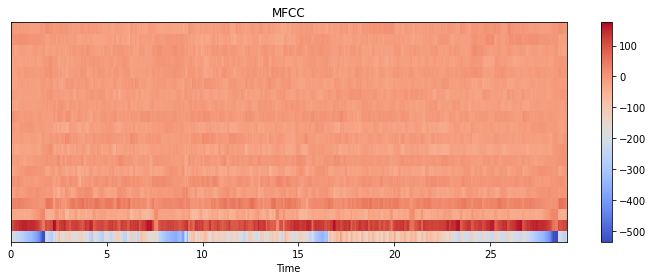

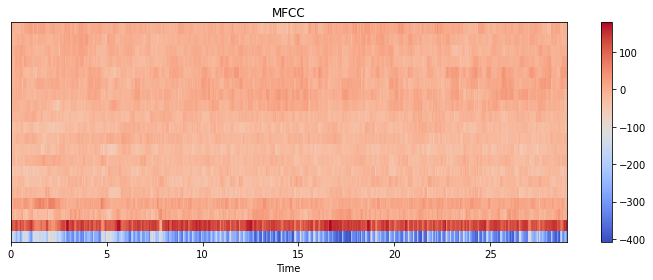

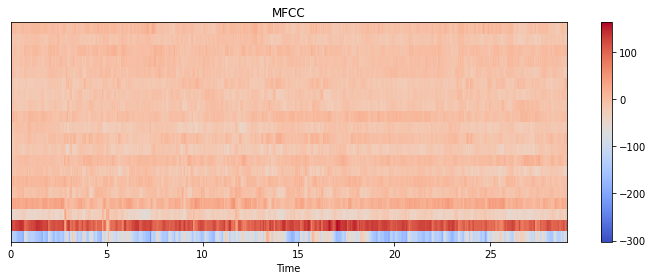

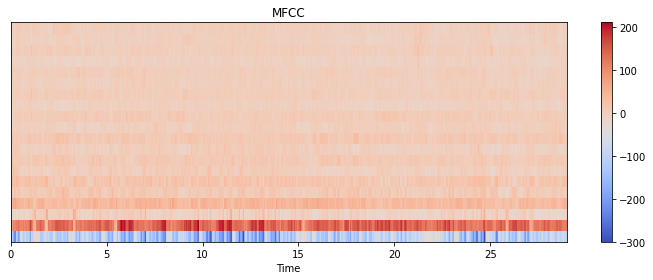

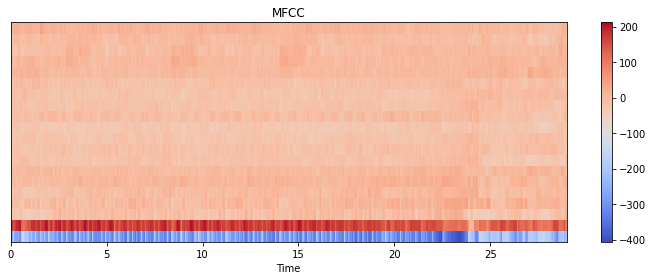

In [6]:
#_displayMFCC("small_set",duration_to_read)

(20, 1293)


/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.1619289  -0.19309777
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


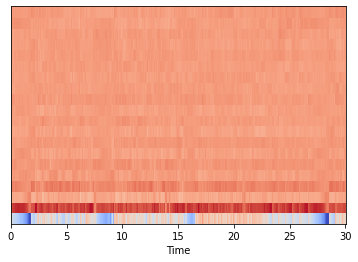

In [10]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

## 1.4 Dimensionality Reduction Using PCA

In [9]:
def _displayMFCCPCA(data_dir, duration):
    audio_files_arr = glob(data_dir + '/*.mp3')
    size = len(audio_files_arr)
    for i in range(size):
        y, sr = librosa.load(audio_files_arr[i],duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        scaler = StandardScaler()
        mfcc_rescaled = scaler.fit_transform(mfcc)
        pca = PCA(n_components = 0.999)
        pca.fit(mfcc_rescaled)
        print("PCA components: ",len(pca.components_))
        print("Explained variance: ",pca.explained_variance_)
        reduced_mfcc = pca.transform(mfcc_rescaled)
        print("Reduced Mfcc: ", reduced_mfcc.shape)
        librosa.display.specshow(reduced_mfcc, x_axis='time')
        plt.colorbar()
        plt.title('MFCC PCA')
        plt.tight_layout()
        # plt.scatter(reduced_mfcc[:,0], reduced_mfcc[:,1])

/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


PCA components:  17
Explained variance:  [1.1949972e+03 7.0342590e+01 1.0382825e+01 8.4124546e+00 5.5175767e+00
 4.1156707e+00 3.3749559e+00 2.8911779e+00 2.3728588e+00 2.0045910e+00
 1.8217143e+00 1.7073406e+00 1.3520397e+00 1.2920886e+00 1.0264208e+00
 9.9439782e-01 8.5066402e-01]
Reduced Mfcc:  (20, 17)


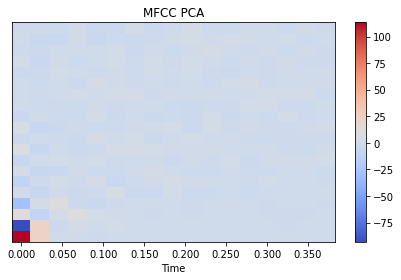

In [10]:
_displayMFCCPCA("small_set", duration_to_read)

Original shape: (20, 1293)
Transformed shape: (1293, 19)


/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/nfs/MLClass/MADT/project3/project3Venv/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


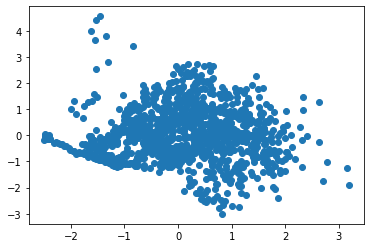

In [11]:
print("Original shape: " + str(mfccs.shape))

mfccs = skl.preprocessing.scale(mfccs)
mfccs.mean()

# Create PCA model object
pca_model = skl.decomposition.PCA(n_components=2, whiten=True)

# Apply PCA to scaled features
pca_model.fit(mfccs.T)
Y = pca_model.transform(mfccs.T)
print("Transformed shape: " + str(Y.shape))

# number of principle components returned:
pca_model.components_.shape

# Plot principle components for each data point
plt.scatter(Y[:,0], Y[:,1])

# Part 2: Classification

Load training data as X_train and y_train

Load test data as X_test and y_test

In [36]:
def _saveTestMFCCToJSon(data_dir,duration):
  jason_data = {
      "mfccs": [],
      "ids": []
  }
  audio_files_arr = glob(data_dir + '/*.mp3')
  size = len(audio_files_arr)
  for i in range(size):
    audio_path = audio_files_arr[i]                 
    id = audio_path[5:13]           
    print(audio_path)
    print(id)
    y, sr = librosa.load(audio_path,duration=duration)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    scaler = StandardScaler()
    mfcc_rescaled = scaler.fit_transform(mfcc)
    pca = PCA(n_components = MFCC_COMPONENTS)
    pca.fit(mfcc_rescaled)
    reduced_mfcc = pca.transform(mfcc_rescaled)

    jason_data["mfccs"].append(reduced_mfcc.tolist())
    jason_data["ids"].append(id)

  with open('mfcc_test.json', "w") as json_file:
    json.dump(jason_data, json_file, indent = 2)

In [ ]:
def _saveTestCENSToJson(data_dir,duration):
  jason_data = {
      "cens": [],
      "ids": []
  }
  audio_files_arr = glob(data_dir + '/*.mp3')
  size = len(audio_files_arr)
  for i in range(size):
    audio_path = audio_files_arr[i]                 
    id = audio_path[5:13]           
    y, sr = librosa.load(audio_path,duration=duration)
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    scaler = StandardScaler()
    chroma_rescaled = scaler.fit_transform(chroma)
    pca = PCA(n_components = CENS_COMPONENTS)
    pca.fit(chroma_rescaled)
    cens = pca.transform(chroma_rescaled)

    jason_data["cens"].append(cens.tolist())
    jason_data["ids"].append(id)

  with open('cens_test.json', "w") as json_file:
    json.dump(jason_data, json_file, indent = 2)

In [ ]:
#_saveTestMFCCToJSon("test",duration_to_read)

In [ ]:
#_saveTestCENSToJson("test",duration_to_read)

## 2.1 SVM

In [22]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import svm

In [17]:
def _getMFCCTrainingDataSVM():
  with open('./mfcc.json', "r") as file:
    data = json.load(file)
  
  mfccs = np.array(data["mfccs"])
  y_train = np.array(data["labels"])
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,y_train

In [6]:
def _getMFCCTestDataSVM():
  with open('./mfcc_test.json', "r") as file:
    data = json.load(file)
  
  mfccs = np.array(data["mfccs"])
  ids = data["id"]
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,ids

In [18]:
X_train_mfcc,Y_train_mfcc = _getMFCCTrainingDataSVM()
X_test_mfcc, mfcc_ids = _getMFCCTestDataSVM()

In [21]:
# SVC Linear from SciKit Learn
svm_linear = skl.svm.LinearSVC(C = 0.01, dual = False, penalty = 'l1', tol = 1e-3, max_iter=3000)
#svm_linear.fit(X_train_mfcc, Y_train_mfcc)
conf_matrix_ls = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_train_mfcc):

   X_train, X_test = X_train_mfcc[train_index], X_train_mfcc[test_index]
   y_train, y_test = Y_train_mfcc[train_index], Y_train_mfcc[test_index]

   svm_linear.fit(X_train, y_train)
   conf_matrix = confusion_matrix(y_test, svm_linear.predict(X_test))
   print("Confusing matrix: ")
   print(conf_matrix)
   conf_matrix_ls .append(conf_matrix)

mean_conf_matrix = np.mean(conf_matrix_ls, axis=0)

print("Mean confusion matrix: ")
print(mean_conf_matrix)

Confusing matrix: 
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 43  60   7 129  29  12]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 20  53   2   9  43  73]]
Confusing matrix: 
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 18  11  32  40   0  19]
 [  0   0   0   0   0   0]
 [ 46  66  12  79   0 157]
 [  0   0   0   0   0   0]]
Confusing matrix: 
[[  5   0   0   1   0   0]
 [116   0  78  32  81  87]
 [  0   0   0   0   0   0]
 [  6   0   9  21   4   0]
 [  5   0   1   5  23   6]
 [  0   0   0   0   0   0]]
Confusing matrix: 
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 72  22 183   0  78   5]
 [  0   0   0   0   0   0]
 [ 16   9  21   0  38  36]]
Confusing matrix: 
[[  0 169  62  82  45  36]
 [  0   2   0   2   1   1]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   9   4   2  28  37]]
Mean confusion matrix: 
[[ 1.  33.8 12.4 16.6  9.   7.2]
 [23.2  0.4 15.6  6.8 16.4 17.6]


In [24]:
# SVM from SciKit Learn
svc = svm.SVC(decision_function_shape='ovo')
conf_matrix_ls = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_train_mfcc):

   X_train, X_test = X_train_mfcc[train_index], X_train_mfcc[test_index]
   y_train, y_test = Y_train_mfcc[train_index], Y_train_mfcc[test_index]

   svc.fit(X_train, y_train)
   conf_matrix = confusion_matrix(y_test, svc.predict(X_test))
   print("Confusing matrix: ")
   print(conf_matrix)
   conf_matrix_ls .append(conf_matrix)

mean_conf_matrix = np.mean(conf_matrix_ls, axis=0)

print("Mean confusion matrix: ")
print(mean_conf_matrix)

Confusing matrix: 
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 24  63   0 165  28   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 18  53   0  13  78  38]]
Confusing matrix: 
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  3  26  29  57   0   5]
 [  0   0   0   0   0   0]
 [ 15 106  19  71   0 149]
 [  0   0   0   0   0   0]]
Confusing matrix: 
[[  5   0   0   1   0   0]
 [116   0 106  46  74  52]
 [  0   0   0   0   0   0]
 [  4   0  11  24   1   0]
 [  6   0   6   5  20   3]
 [  0   0   0   0   0   0]]
Confusing matrix: 
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 26  33 276   0  25   0]
 [  0   0   0   0   0   0]
 [ 12  11  19   0  55  23]]
Confusing matrix: 
[[  0 217  56  71  31  19]
 [  0   4   1   1   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0  10   4   2  30  34]]
Mean confusion matrix: 
[[ 1.  43.4 11.2 14.4  6.2  3.8]
 [23.2  0.8 21.4  9.4 14.8 10.4]


## 2.2 Neural Network

In [13]:
def _getMFCCTrainingData():
  with open('./mfcc.json', "r") as file:
    data = json.load(file)
  
  mfccs = np.array(data["mfccs"])
  y_train = np.array(data["labels"])
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,to_categorical(y_train)

In [14]:
def _getMFCCTestData():
  with open('./mfcc_test.json', "r") as file:
    data = json.load(file)
  
  mfccs = np.array(data["mfccs"])
  ids = data["id"]
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,ids

In [15]:
def _getCENSTrainingData():
  with open('./cens.json', "r") as file:
    data = json.load(file)
  
  mfccs = np.array(data["cens"])
  y_train = np.array(data["labels"])
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,to_categorical(y_train)

In [16]:
def _getCENSTestData():
  with open('./cens_test.json', "r") as file:
    data = json.load(file)
  
  mfccs = np.array(data["cens"])
  ids = data["ids"]
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,ids

In [17]:
X_train_mfcc,Y_train_mfcc = _getMFCCTrainingData()
X_test_mfcc, mfcc_ids = _getMFCCTestData()

In [18]:
X_train_cens, Y_train_cens = _getCENSTrainingData()
X_test_cens, cens_ids = _getCENSTestData() 

In [19]:
print("MFCC features: ", X_train_mfcc.shape)
print("CENS features: ", X_train_cens.shape)
mfcc_features = 340
cens_features = 132
outputs = 6

MFCC features:  (2400, 340)
CENS features:  (2400, 132)


In [20]:
# create model 
mfcc_model = Sequential()
mfcc_model.add(Dense(400, input_dim=mfcc_features, activation='relu'))
mfcc_model.add(Dense(outputs, activation='softmax'))
# Compile model
mfcc_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
#Cross validation 
mfcc_estimator = KerasClassifier(model=mfcc_model, epochs=20, batch_size=35, verbose=0)
kfold = KFold(n_splits=10, random_state=5, shuffle=True)
scores = cross_val_score(mfcc_estimator, X_train_mfcc, Y_train_mfcc, cv=kfold)
print("MFCC: %.2f%% (%.2f%%)" % (scores.mean()*100, scores.std()*100))
mfcc_estimator.fit(X_train_mfcc,Y_train_mfcc)
mfcc_predictions = np.argmax(mfcc_estimator.predict(X_test_mfcc), axis=1)

INFO:tensorflow:Assets written to: ram:///tmp/tmp058uu44a/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5rn5dzvq/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmppct3njit/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp2ky2r9jo/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpyu7t2jzc/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpmjekz_xo/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpsi7owsvx/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpgjymoygj/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpwameofze/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpz790yr5r/assets
MFCC: 40.67% (4.15%)


In [ ]:

# Or this. Skip cross validation (Cell above) to run this
#This is faster.
#mfcc_model.fit(X_train_mfcc, Y_train_mfcc, validation_split=0.33, epochs=100, batch_size=35)
#mfcc_predictions = numpy.argmax(mfcc_model.predict(X_test_mfcc), axis=1)

In [22]:
_writePredictionsTofile(mfcc_ids,mfcc_predictions.tolist())

## 2.3 Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
model = LogisticRegression(C=10, max_iter=10000)

In [54]:
def _writePredictionsTofileLR(ids, predictions):
    with open("predictionsLR.csv", "w", newline="") as file:
        fieldnames = ["id", "genre"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        size = len(ids)
        for x in range(size):
            writer.writerow({"id": ids[x], "genre": predictions[x]})

In [55]:
def _getMFCCTrainingDataLR():
  with open('./mfcc.json', "r") as file:
    data = json.load(file)
  
  mfccs = np.array(data["mfccs"])
  y_train = np.array(data["labels"])
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,to_categorical(y_train)

In [56]:
def _getMFCCTestDataLR():
  with open('./mfcc_test.json', "r") as file:
    data = json.load(file)
  
  mfccs = np.array(data["mfccs"])
  ids = data["id"]
  x,y,z = mfccs.shape
  X = mfccs.reshape(x, y*z)

  return X,ids

In [57]:
X_train_mfcc,Y_train_mfcc = _getMFCCTrainingDataLR()
X_test_mfcc, mfcc_ids = _getMFCCTestDataLR()

In [58]:
model.fit(X_train,y_train)


LogisticRegression(C=10, max_iter=10000)

In [59]:
# changing C=10 increase score by .2
model.score(X_train,y_train)


0.6654166666666667

In [60]:
lr_prediction = model.predict(X_test_mfcc)

In [62]:
_writePredictionsTofileLR(mfcc_ids,lr_prediction.tolist())